In [97]:
import img
from PIL import Image
import numpy as np
import random
import importlib

[[157.  157.  157.  ... 153.  154.  127.5]
 [157.  157.  157.  ... 153.  154.  154. ]
 [157.  157.  157.  ... 153.  153.  153. ]
 ...
 [127.  127.  120.  ... 133.  124.  124. ]
 [113.  113.  137.  ... 127.  106.  106. ]
 [127.5 113.  137.  ... 127.  106.  127.5]]


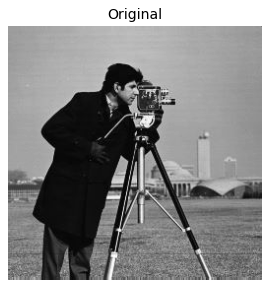

In [98]:
importlib.reload(img)

org = img.original(1)
print(org*255)
img.inlineImg(org, 'Original', True)

[[157.35850869 152.39622543 183.43041629 ... 144.92373362 160.15860148
  107.29805263]
 [149.81204795 168.54202106 178.99773886 ... 147.10998351 189.34712296
  121.34174503]
 [182.49823371 135.59315108 168.27017575 ... 181.17749337 157.02588883
  126.23636705]
 ...
 [113.51268211 114.2826472  142.25889606 ... 133.09616459 120.20162267
  100.60468032]
 [ 90.9594105  104.67994914 107.44110994 ... 125.35630043 113.58066115
   94.33220656]
 [124.32952571 129.63358737 139.3303171  ... 128.4104148  107.37464195
  111.81948525]] (258, 258)


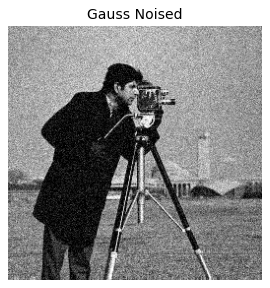

In [114]:
gaussNoised = img.gaussNoised(1,20)
print(gaussNoised*255, gaussNoised.shape)
img.inlineImg(gaussNoised, 'Gauss Noised', True)

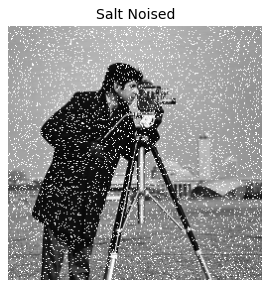

In [82]:
saltNoised = img.saltNoised(1,0.1)
img.inlineImg(saltNoised, 'Salt Noised')

In [5]:
print(gaussNoised.shape)
img.showImg(gaussNoised[10:40,0:20])

(258, 258)


# 定义需要优化的函数

首先是TV的选择，我们用L2norm
$$
\|X\|_{T V}=\sum_{i=1}^{n-1} \sum_{j=1}^{n-1} \sqrt{\left(X_{i, j}-X_{i+1, j}\right)^{2}+\left(X_{i, j}-X_{i, j+1}\right)^{2}}
$$
然后是相似性计算，使用
$$
\text {disimilarity}=\|F-X\|_{2}^{2}
$$
最后综合一下
$$
\min _{X} \lambda\|X\|_{T V}+\|F-X\|_{2}^{2}
$$

In [6]:
def int8array2float64array(x):
    x = np.array(x)
    x = x.astype(np.float64)
    return x

In [7]:
## 计算 TV
import math
def TV(x):
    # calculate total variant of a picture x
    tv = 0
    for i in range(x.shape[0]-1):
        for j in range(x.shape[1]-1):
            diff1 = (x[i][j]-x[i+1][j])
            diff2 = (x[i][j]-x[i][j+1])
            l2_norm = math.sqrt(diff1*diff1 + diff2*diff2)
            tv+=l2_norm
    return tv
    
def TV2(x):
    # tv faster
    # calculate total variant of a picture x
    tv = 0
    for i in range(x.shape[0]-1):
        for j in range(x.shape[1]-1):
            # np.linalg.norm(x1-x2, ord=None, axis=None, keepdims=False)
            l2_norm = np.linalg.norm([x[i][j]-x[i+1][j],\
                                      x[i][j]-x[i][j+1]],ord=2)
            tv+=l2_norm
    return tv
    

In [8]:
## 计算相似性
def dissimilarity(f,x):
    # L2 norm square
    # f anf x must be the same size
    simi = 0
    for i in range(x.shape[0]):
        for j in range(x.shape[1]):
            diff = (x[i][j]-f[i][j])
            simi += diff*diff
    return simi

def dissimilarity2(f,x):
    # L2 norm square
    # f anf x must be the same size
    diff = f-x
    simi = np.linalg.norm(diff.reshape(-1,1),ord=2,axis = None)
    return simi*simi


In [9]:
# 综合公式
def score(x, f, lambda_ = 0.05):
    # f is the original image, x is our denoised image
    # and lambda is the rate of denoising
#     x = int8array2float64array(x)
#     f = int8array2float64array(f)
    score_ = lambda_ * TV(x) + (1-lambda_)*dissimilarity(f,x)
    return score_


# 要计算 delta x, 就要先求函数的梯度
首先是tv部分，每个$x_{ij}$都有3个公式和他有关，公式是形似的，分别求导如下
$$
\frac{\partial}{\partial x}(\sqrt{(x-a)^{2}+(x-b)^{2}})= 
\frac{-a-b+2 x}{\sqrt{a^{2}-2 a x+b^{2}-2 b x+2 x^{2}}}
$$
和
$$
\frac{\partial}{\partial x}(\sqrt{(a-x)^{2}+(a-b)^{2}})=-\frac{a-x}{\sqrt{(a-b)^{2}+(a-x)^{2}}}
$$
然后是对dissimilarity的求导
$$
\frac{\partial}{\partial x}\left((a-x)^{2}\right)=2 x-2 a
$$

In [10]:
def delTV(L, R, U, D, LD, UR, x):
    # 输入上下左右, LD(左下), UR（右上）和x本身，求在x处的偏导
    # 此处x为 X_ij
    def delTV1(a,b,x):
        divider = a*a - 2*a*x + b*b - 2*b*x + 2*x*x
        return (-a-b+2*x)/math.sqrt(divider) if divider>0 else 0
    def delTV2(a,b,x):
        divider = math.sqrt((a-b)*(a-b)+(a-x)*(a-x))
        return (-a+x)/divider if divider>0 else 0
    return delTV1(D, R, x) + delTV2(L,LD,x) + delTV2(U,UR,x)

def delSimi(a, x):
    # 此处x为 X_ij
    return 2*x - 2*a

def delXij(f, x, i, j, lambda_):
    # return lambda_*delTV(L, R, U, D, LD, UR, x) + delSimi(a, x)
    # 注意！不能当Xij在边界上使用
    L, R, U, D, LD, UR, Xij = x[i-1][j], x[i+1][j], \
    x[i][j-1], x[i][j+1], x[i-1][j+1], x[i+1][j-1], x[i][j]
    return lambda_*delTV(L, R, U, D, LD, UR, Xij) + (1-lambda_)*delSimi(f[i][j] , x[i][j])
    
# print(delXij(f, x, 2, 3))
    

In [11]:
# 计算整张表格，边缘暂时用0代替
def delF(f, x, lambda_):
    del_f = np.zeros([x.shape[0],x.shape[1]])
    del_f = int8array2float64array(del_f)
    for i in range(x.shape[0]-2):
        for j in range(x.shape[1]-2): 
            del_f[i+1][j+1] = delXij(f, x, i+1, j+1, lambda_)
#     del_x = int8array2float64array(del_x)
    return del_f

def delX(f, x, lambda_):
    return - delF(f, x, lambda_)
    
# print(delX(f, x))

# 然后计算t，使得最优（exact search） 
使用np.array简单操作
首先转换为double精度，然后再继续

In [89]:
# given a start point x in dom f
f = gaussNoised # this is a 2-axes matrix
x = f.copy()
x = int8array2float64array(x)
f = int8array2float64array(f)
assert x is not f

In [13]:
delta_x = delX(f, x, 0.3)

# print( delta_x.shape)
# 有两个数组，px and py
# delta_x = np.array(delta_x)
# delta_x.shape

In [14]:
# find the t to minimize f(x + t * delta_x)
# first, 用倍增法找到 a, b 两个点， 使得中点值小于平均值

def getABinDirT( fun , start_x , direction , f, lambda_):
    a = 0.0
    b = 0.06
    score_a = fun(start_x + a*direction, f, lambda_)
    score_b = fun(start_x + b*direction, f, lambda_)
#     print('score_a , score_b',score_a , score_b)
    if score_a == score_b:
        return [a, b]
    elif score_a < score_b:
        return [a, b]
    while score_a > score_b:
#         a = b
        b = 2*b
        score_b = fun(start_x + 2*b*direction, f, lambda_)
    return [a, b]
    
getABinDirT(score, x, delta_x, f, 0.6)

[0.0, 0.12]

In [15]:
# second, use Line Search: by Function Value
def getT1T2(a, b):
    t1 = a + (b-a) * 0.382
    t2 = a + (b-a) * 0.618
    return t1, t2

def functionValueLineSearchHelper(fun, x, delta_x, a, b, f, lambda_, e):
    t1, t2 = getT1T2(a, b)
    x1 = x + t1*delta_x
    x2 = x + t2*delta_x
    f2 = fun(x2, f, lambda_)
    f1 = fun(x1, f, lambda_)
    while (b-a) > e:
#         print([a,b], end = '')
#         print([t1, t2])
#         print('f1,f2',f1, f2)
        if f2 > f1:
            b = t2
            t2 = t1
            f2 = f1
            t1 = a + (b-a) * 0.382
            x1 = x + t1*delta_x
            f1 = fun(x1, f, lambda_)
        else:
            a = t1
            t1 = t2
            f1 = f2
            t2 = a + (b-a) * 0.618
            x2 = x + t2*delta_x
            f2 = fun(x2, f, lambda_)
#         
            
#     print('Finally, [t1, t2] =',[t1, t2])
    return t2, f2

def functionValueLineSearchHelper2(fun, x, delta_x, a, b, f, lambda_, e):
    t1, t2 = getT1T2(a, b)
    x1 = x + t1*delta_x
    x2 = x + t2*delta_x
    f2 = fun(x2, f, lambda_)
    f1 = fun(x1, f, lambda_)
    
    return t2, f2

def functionValueLineSearch(fun, start_x, direction, f, lambda_, e):
    [a, b] = getABinDirT(fun, start_x, direction, f, lambda_)
#     print('[a, b] =',[a,b])

#     [a,b] = [1,10]
    t, score_t = functionValueLineSearchHelper(fun, start_x, direction, a, b, f, lambda_, e)
#     print('t, score_t = ',t, score_t)
    return t, score_t

t, score_t = functionValueLineSearch(score, x, delta_x, f, 0.6, 10e-1)
print(t, score_t)

0.07415999999999999 3527.283513495979


# 尝试使用全部代码进行测试
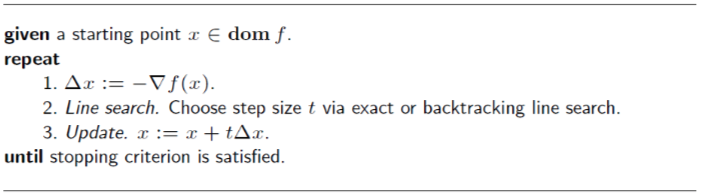

In [100]:
f = gaussNoised # this is a 2-axes matrix
x = f.copy()
x = int8array2float64array(x)
f = int8array2float64array(f)
assert x is not f

In [74]:

def l2normDelX(f, x, lambda_ = 0.05):
    del_x = delX(f, x, lambda_)
    return np.linalg.norm(del_x.reshape(-1,1),ord=2,axis = None)

def l2normDelF(del_f):
    return np.linalg.norm(del_f.reshape(-1,1),ord=2,axis = None)

l2normDelX(f, x)

25.739926973964007

In [172]:
def getSplitRange(x, k):
    x_x = x.shape[0]-2
    x_y = x.shape[1]-2
    full_x = x_x//k
    rem_x = x_x%k
    full_y = x_y//k
    rem_y = x_y%k
    x_range = [ (i*k, i*k+k+2) if i*k+k+2 <= x_x+2 else (i*k, None)  for i in range(full_x+ int(rem_x!=0))]
    y_range = [( i*k, i*k+k+2) if i*k+k+2 <= x_y+2 else (i*k, None)  for i in range(full_y+ int(rem_y!=0))]
    return x_range , y_range

def getSplitRange2(x, k):
    x_x = x.shape[0]-2
    x_y = x.shape[1]-2
    full_x = x_x//k
    rem_x = x_x%k
    full_y = x_y//k
    rem_y = x_y%k
    x_range = [ (i*k+1, i*k+k+1) if i*k+k+1 <= x_x+2 else (i*k+1, -1)  for i in range(full_x+ int(rem_x!=0))]
    y_range = [( i*k+1, i*k+k+1) if i*k+k+1 <= x_y+2 else (i*k+1, -1)  for i in range(full_y+ int(rem_y!=0))]
    return x_range , y_range
    
    
def getWeightTable(x, f, fun, lambda_, k):
    # x is the image, k is the length of the side of the block
    # k = 1, 2, 3, 4, 5, ....
    x_dup = x.copy()
    f_dup = f.copy()
    x_range, y_range = getSplitRange(x, k)
    
    weight = np.zeros((len(x_range), len(y_range)))
    for i in range(len(x_range)):
        for j in range(len(y_range)):
            x_local = x_dup[x_range[i][0]:x_range[i][1], y_range[j][0]:y_range[j][1] ]
            f = f_dup[x_range[i][0]:x_range[i][1], y_range[j][0]:y_range[j][1] ]
            weight[i,j] = fun(x_local, f, lambda_)
            if x_local.shape[0] < k and x_local.shape[1]<k:
                print(x_local*255)
    return weight

def splitTest():
    x_range , y_range = getSplitRange(x, 3)
    x_range2 , y_range2 = getSplitRange2(x, 3)
    print(x_range,x_range2)
# splitTest()

[(0, 5), (3, 8), (6, 11), (9, 14), (12, 17), (15, 20), (18, 23), (21, 26), (24, 29), (27, 32), (30, 35), (33, 38), (36, 41), (39, 44), (42, 47), (45, 50), (48, 53), (51, 56), (54, 59), (57, 62), (60, 65), (63, 68), (66, 71), (69, 74), (72, 77), (75, 80), (78, 83), (81, 86), (84, 89), (87, 92), (90, 95), (93, 98), (96, 101), (99, 104), (102, 107), (105, 110), (108, 113), (111, 116), (114, 119), (117, 122), (120, 125), (123, 128), (126, 131), (129, 134), (132, 137), (135, 140), (138, 143), (141, 146), (144, 149), (147, 152), (150, 155), (153, 158), (156, 161), (159, 164), (162, 167), (165, 170), (168, 173), (171, 176), (174, 179), (177, 182), (180, 185), (183, 188), (186, 191), (189, 194), (192, 197), (195, 200), (198, 203), (201, 206), (204, 209), (207, 212), (210, 215), (213, 218), (216, 221), (219, 224), (222, 227), (225, 230), (228, 233), (231, 236), (234, 239), (237, 242), (240, 245), (243, 248), (246, 251), (249, 254), (252, 257), (255, None)] [(1, 4), (4, 7), (7, 10), (10, 13), (1

[[0.13450294 0.16761116 0.20714962 ... 0.16495339 0.15597607 0.18557702]
 [0.19520161 0.11125533 0.17149419 ... 0.16010198 0.17612836 0.15403473]
 [0.21862473 0.13375727 0.18208953 ... 0.21587727 0.22269865 0.0951424 ]
 ...
 [0.21232496 0.31067022 0.23045915 ... 0.18352673 0.20437649 0.28145243]
 [0.23199107 0.30746363 0.26945671 ... 0.26969048 0.35488456 0.23551128]
 [0.22902982 0.27603862 0.30639448 ... 0.34134783 0.32427132 0.29991752]]


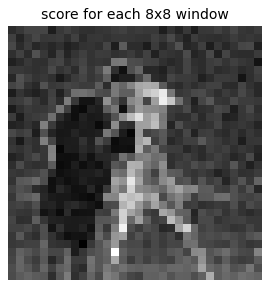

In [145]:
importlib.reload(img)
def testWeight(side):
#     def l2dd( x_local, f, lambda_):
#         del_x = delX(f, x_local, lambda_)
#         norm_del = l2normDelF(del_x)
    weight = getWeightTable(x, f,score, 0.9, side)
    max_w = weight.max()
    min_w = weight.min()
    print((weight-min_w)/max_w)
    img.inlineImg(weight/max_w, f'score for each {side}x{side} window', True)
#     weight = getWeightTable(x, f,l2dd, 0.9, 8)
#     max_w = weight.max()
#     print(weight/max_w)
#     img.inlineImg(weight/max_w)
    
testWeight(8)


In [192]:
# import copy
import time
%matplotlib inline
import matplotlib.pyplot as plt 
import random

def imgShowInline(x_local):
    # 截掉边缘后打印
    plt.imshow(img.showImg(x_local),cmap='gray')
    plt.axis('off')
#     plt.title('iteration - '+str(i)) # 图像题目
    plt.show()
    
def bestX(fun, f, x, lambda_, e, eps, max_it, k):
#     imgShowInline(org)
#     imgShowInline(gaussNoised)
#     img.showImg(gaussNoised).show()
    # e 为functionValueLineSearch 用的接近值
    # esp 为 del F norm 用的接近值
    itr = 0 # iteration
    norm_del = 10
    x_dup = x.copy()
    f_dup = f.copy()
    img_a = x_dup.shape[0]
    img_b = x_dup.shape[1]
    
    iteration_l = []
    norm_del_f_l = []
    score_l = []
    time_l = []
    
#     bound = 4 # 1表示3x3矩阵，2表示5x5矩阵
#     bound += 1
    
#     mm = [max_it*(i)//20 for i in range(20)]
    x_range, y_range = getSplitRange(x, k)
    x_range2 , y_range2 = getSplitRange2(x, k)
    while  norm_del> eps and itr < max_it: 
        start = time.time()
        for i in range(len(x_range)):
            for j in range(len(y_range)):
                x_local = x_dup[x_range[i][0]:x_range[i][1], y_range[j][0]:y_range[j][1] ]
                f = f_dup[x_range[i][0]:x_range[i][1], y_range[j][0]:y_range[j][1] ]
                del_x = delX(f, x_local, lambda_)

                
                t, score_t = functionValueLineSearch(fun, x_local, del_x, f, lambda_, e)
                
                x_local += t*del_x
                assert x_dup[x_range2[i][0]:x_range2[i][1], y_range2[j][0]:y_range2[j][1] ].shape \
                    == x_local[1:-1,1:-1].shape
                x_dup[x_range2[i][0]:x_range2[i][1], y_range2[j][0]:y_range2[j][1] ] = x_local[1:-1,1:-1]
        end = time.time()
        
        score_t = fun(x_dup, f_dup, lambda_)
        
        iteration_l.append(itr)
        time_l.append(end-start)
        score_l.append(score_t)
        del_x = delX(f_dup, x_dup, lambda_)
        norm_del = l2normDelF(del_x)
        norm_del_f_l.append(norm_del)
#         print('iteration',itr,'norm2 delF',norm_del_f_l[-1], 'score', score_l[-1])
#         img.inlineImg(x_dup)
        if np.floor(itr/float(max_it)*100)%10 == 0: print('iteration',itr,'norm2 delF',
                                                          norm_del_f_l[-1], 'score', score_l[-1])
        if np.floor(itr/float(max_it)*100)%10 == 0: 
            img.inlineImg(x_dup)
            img.sava(x_dup, 'iteration-'+str(itr), img_folder = f'GD-stochastic-general-full-s={k}')
        itr+=1
    return x_dup, [iteration_l, norm_del_f_l, score_l, time_l]
        
# best_x = bestX(score, f, x, 0.999, 10e-9, 10e-3, 101)

# 尝试将数据保存为文件
iteration，norm_del_F, score_t, time(ms)

In [1]:
block_size = 4
best_x, [iteration_l, norm_del_f_l, score_l, time_l] = bestX(score, f, x, 0.9, 10e-9, 10e-3, 101, k=block_size)
# img.sava(best_x, 'iteration-last', img_folder = 'GD-exact')

NameError: name 'bestX' is not defined

In [2]:
import pickle
def save2picke(data, file_name):
    with open('./pickle/'+file_name+'.pickle', 'wb') as f:
        pickle.dump(data, f)
        
def read4picke(file_name):
    with open('./pickle/'+file_name+'.pickle', 'rb') as f:
        return pickle.load(f)
    assert 'there is no such file' == 0
        
# kk = read4picke('score for GD_primary')
# print(kk)
def saveMsgAsPickle(FileName, iteration_l, norm_del_f_l, score_l, time_l):
    save2picke(score_l, FileName + 'score_l')
    save2picke(time_l, FileName + 'time_l')
    save2picke(iteration_l, FileName + 'iteration_l')
    save2picke(norm_del_f_l, FileName + 'norm_del_f_l')
    
def getMsgFromPickle(FileName):
    score_l = read4picke(FileName + 'score_l')
    time_l = save2picke(FileName + 'time_l')
    iteration_l = save2picke(FileName + 'iteration_l')
    norm_del_f_l = save2picke(FileName + 'norm_del_f_l')
    return iteration_l, norm_del_f_l, score_l, time_l

saveMsgAsPickle('stochastic-general-k'+str(block_size)+'-', iteration_l, norm_del_f_l, score_l, time_l)

NameError: name 'iteration_l' is not defined

In [ ]:
img.showImg(best_x)

In [ ]:
img.showImg(org)

In [ ]:
# import matplotlib.pyplot as plt
# time_l_new = [sum(time_l[:i]) for i in range(len(time_l))]
# plt.plot(time_l_new, score_l, marker='^', linestyle='-',label=r'$f\ (x^{k})$'+' vs time')
# plt.ylabel(r'$f\ (x^{k})$')
# plt.xlabel(r'$time\ (s)$')
# plt.legend()
# plt.title(r'$f\ (x^{k})$ vs time with general gradient descent')
# plt.savefig("./gen-img/plot/$f\ (x^{k})$ vs time with general gradient descent.png", dpi=300)
# plt.show()

In [ ]:
# plt.plot(iteration_l, score_l, marker='^', linestyle='-',label=r'$f\ (x^{k})$'+' vs '+'iteration '+r'$k$')
# plt.ylabel(r'$f\ (x^{k})$')
# plt.xlabel('iteration '+r'$k$')
# plt.legend()
# plt.title(r'$f\ (x^{k})$ vs iteration $k$ with general gradient descent')
# plt.savefig("./gen-img/plot/$f\ (x^{k})$ vs iteration $k$ with general gradient descent.png", dpi=300)
# plt.show()

In [ ]:
# print(score_l)

